# Paige & Cong's Module 1 Final Project


## Import Libraries

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
!pip install mysql-connector-python

In [74]:
import mysql.connector

In [75]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

## Load SQL queries and adjust data

In [76]:
tn = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tn_movie_budgets""", con))

In [77]:
#Change data types
tn['domestic_gross'] = tn['domestic_gross'].str.replace('$','')  
tn['domestic_gross'] = tn['domestic_gross'].str.replace(',','')
tn['domestic_gross'] = tn['domestic_gross'].astype(float)
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace('$','')
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace(',','')
tn['worldwide_gross'] =tn['worldwide_gross'].astype(float) 
tn['production_budget'] =tn['production_budget'].str.replace('$','')
tn['production_budget'] =tn['production_budget'].str.replace(',','')
tn['production_budget'] =tn['production_budget'].astype(float) 
tn['release_date'] = pd.to_datetime(tn['release_date'])

In [78]:
bom = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.bom_movie_gross""", con))

In [79]:
tmd = pd.DataFrame(pd.read_sql_query("""
SELECT
	title,
    vote_average,
    popularity,
    release_date
FROM movies.tmdb_movies""", con))

In [80]:
#Change data types
tmd['release_date'] = pd.to_datetime(tmd['release_date'])

In [81]:
#Drop duplicates
tmd = tmd.drop_duplicates(subset='title',keep=False)

In [82]:
imdb_title_basics = pd.DataFrame(pd.read_sql_query("""
SELECT 
	primary_title,
    genres,
    start_year
FROM movies.imdb_title_basics""", con))

In [83]:
# Format data and change datatypes
imdb_title_basics['title_new'] = imdb_title_basics['primary_title'].apply(lambda x: x.replace(' ',''))
imdb_title_basics['title_new'] = imdb_title_basics['title_new'].apply(lambda x: x.lower())
imdb_title_basics['title_new_year'] = imdb_title_basics['title_new'] + imdb_title_basics['start_year'].astype(str)

In [84]:
imdb_title_crew_df = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_title_crew;
""",con)

In [85]:
imdb_title = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_title_basics;
""",con)

In [86]:
imdb_people = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_name_basics;
""",con)

In [87]:
imdb_ratings = pd.read_sql_query("""
SELECT 
	tconst,
    averagerating,
    numvotes
FROM movies.imdb_title_ratings
""",con)

## Combine SQL queries into dataframes

### 'tbi' dataframe
Includes production budget, domestic / worldwide gross, genre, release date <br>
Combination of 'bom_movie_gross', 'tn_movie_budgets', 'tmdb_movies', 'imdb_title_basics'

In [88]:
# JOIN bom and tn
tb = tn.join(bom.set_index('title'),
             on='movie',
             how='outer',
             lsuffix='_tn',
             rsuffix='_bom')

In [89]:
# JOIN tb with tmd and edit table
tbt = tb.join(
        tmd.set_index('title'),
        on='movie',
        how='left',
        rsuffix='_tmd')

In [90]:
tbt['release_date'] = np.where(tbt['release_date'].isna(), tbt['release_date_tmd'], tbt['release_date']) 

In [91]:
tbt = tbt.drop(columns='release_date_tmd')

In [92]:
tbt['year'] = np.where(tbt['release_date'].isna(), tbt['year'], tbt['release_date'].dt.year)
tbt['movie_new'] = tbt['movie'].apply(lambda x: x.replace(' ',''))
tbt['movie_new'] = tbt['movie_new'].apply(lambda x: x.lower())
tbt['movie_new_year'] = tbt['movie_new'] + tbt['year'].astype(str)
tbt['movie_new_year'] = tbt['movie_new_year'].apply(lambda x: x.replace('.0','')) 

In [93]:
# JOIN tbt with imdb_title_basics and edit table
tbi = tbt.join(imdb_title_basics.set_index('title_new_year'),
        on='movie_new_year',
        how='left',
        rsuffix='_imdb')

In [94]:
tbi = tbi.drop_duplicates(subset = 'movie')

In [95]:
tbi['domestic_gross_tn'] = np.where(tbi['domestic_gross_tn'].isna(), tbi['domestic_gross_bom'], tbi['domestic_gross_tn']) 
tbi = tbi.drop(columns=['domestic_gross_bom','studio'])
tbi['release_month'] = tbi['release_date'].dt.month
tbi = tbi.rename(columns={'production_budget':'production_budget_$m','domestic_gross_tn':'domestic_gross_$m','worldwide_gross':'worldwide_gross_$m', 'foreign_gross':'foreign_gross_$m'})

In [96]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))

In [97]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].astype(float)
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].astype(float)
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].astype(float)
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].astype(float)

In [98]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['global_mom'] = tbi['worldwide_gross_$m'] / tbi['production_budget_$m']
tbi = tbi.round({'global_mom':2})

In [99]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['release_month'] = tbi['release_date'].dt.month

In [100]:
tbi['worldwide_gross_$m'] = np.where(tbi['worldwide_gross_$m'].isna(), tbi['domestic_gross_$m'] + tbi['foreign_gross_$m'], tbi['worldwide_gross_$m'])

In [101]:
tbi = tbi.drop(columns=['year','start_year','movie_new'])

In [102]:
tbi.head()

,id,release_date,movie,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,vote_average,popularity,movie_new_year,primary_title,genres,title_new,release_month,release_year,global_mom
0.0,1.0,2009-12-18,Avatar,425.0,761.0,2776.0,NaN,7.4,26.526,avatar2009,NaN,NaN,NaN,12.0,2009.0,6.53
1.0,2.0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,411.0,241.0,1046.0,805.0,6.4,30.579,piratesofthecaribbean:onstrangertides2011,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",piratesofthecaribbean:onstrangertides,5.0,2011.0,2.55
2.0,3.0,2019-06-07,Dark Phoenix,350.0,43.0,150.0,NaN,NaN,NaN,darkphoenix2019,Dark Phoenix,"Action,Adventure,Sci-Fi",darkphoenix,6.0,2019.0,0.43
3.0,4.0,2015-05-01,Avengers: Age of Ultron,331.0,459.0,1403.0,946.0,7.3,44.383,avengers:ageofultron2015,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",avengers:ageofultron,5.0,2015.0,4.24
4.0,5.0,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317.0,620.0,1317.0,NaN,NaN,NaN,starwarsep.viii:thelastjedi2017,NaN,NaN,NaN,12.0,2017.0,4.15


In [103]:
# Create a dataset that has one row per genre
tbi_genre= pd.DataFrame(tbi.genres.str.split(',').tolist(), index=tbi.movie).stack()
tbi_genre =tbi_genre.reset_index([0, 'movie'])
tbi_genre = tbi_genre.join(tbi.set_index('movie'),on='movie')
tbi_genre = tbi_genre.rename(columns={0:'genre'})
tbi_genre = tbi_genre.explode('genre')
tbi_genre = tbi_genre.drop(columns='genres')
tbi_genre['release_month'] = tbi_genre['release_date'].dt.month

### 'imdb' dataframe
Includes director names, genre, ratings <br>
Combination of 'imdb_title_crew', 'imdb_title_basics', 'imdb_name_basics', 'imdb_title_ratings'

In [104]:
# One column per each director identifier
imdb_test = imdb_title_crew_df['directors'].str.split(pat=',',expand=True)

In [105]:
imdb_test.iloc[ : ,1].isna().sum() 
# Out of 146144 movies, 130417 have only 1 director  

130417

In [106]:
# Add movie identifier to table
imdb_test['tconst'] = imdb_title_crew_df['tconst']

In [107]:
# Drop irrelevant columns
imdb_test = imdb_test.drop(imdb_test.iloc[:,3:26], axis = 1)

In [108]:
# Rename table columns
imdb_title_crew_df['dir1'] = imdb_test[0]
imdb_title_crew_df['dir2'] = imdb_test[1]
imdb_title_crew_df['dir3'] = imdb_test[2]

In [109]:
# Rename table to something shorter
imdb_crew = imdb_title_crew_df

In [110]:
# One column per each writer identifier
writers = imdb_title_crew_df['writers'].str.split(pat=',',expand=True)

In [111]:
writers.iloc[:,3].isna().sum() 
# Out of 146144 movies, 140714 have only max 3 writers 

140714

In [112]:
# Rename table columns
imdb_crew['wri1'] = writers[0]
imdb_crew['wri2'] = writers[1]
imdb_crew['wri3'] = writers[2]

In [113]:
# Add director and writer names to the table
imdb = imdb_title.set_index('tconst').join(imdb_crew.set_index('tconst'))
nconst_to_names = imdb_people.loc[:, ['nconst','primary_name']]
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir1',
          rsuffix='_names')
imdb = imdb.rename(columns={'primary_name':'dir1_name'})
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir2',
          rsuffix='_names')
imdb = imdb.rename(columns={'primary_name':'dir2_name'})
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir3',
          rsuffix='_names')
imdb = imdb.rename(columns={'primary_name':'dir3_name'})
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri1',
          rsuffix='_names')
imdb = imdb.rename(columns={'primary_name':'wri1_name'})
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri2',
          rsuffix='_names')
imdb = imdb.rename(columns={'primary_name':'wri2_name'})
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri3',
          rsuffix='_names')
imdb = imdb.rename(columns={'primary_name':'wri3_name'})
imdb = imdb.reset_index()

In [114]:
# Add ratings to the table
imdb = imdb.join(imdb_ratings.set_index('tconst'),
          on='tconst',
          rsuffix='_ratings')

In [115]:
# One genre per column 
imdb[['genre1','genre2','genre3']] = imdb['genres'].str.split(pat=',',expand=True)

In [116]:
imdb.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,dir1,dir2,...,dir2_name,dir3_name,wri1_name,wri2_name,wri3_name,averagerating,numvotes,genre1,genre2,genre3
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276",nm0712540,None,...,NaN,NaN,Abrar Alvi,Mahasweta Devi,Gulzar,7.0,77.0,Action,Crime,Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",nm0002411,None,nm0002411,None,...,NaN,NaN,NaN,NaN,NaN,7.2,43.0,Biography,Drama,None
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,nm0000080,"nm0000080,nm0462648",nm0000080,None,...,NaN,NaN,Orson Welles,Oja Kodar,NaN,6.9,4517.0,Drama,None,None
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",nm0611531,nm0347899,nm0611531,None,...,NaN,NaN,Gulzar,NaN,NaN,6.1,13.0,Comedy,Drama,None
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy","nm0765384,nm0749914","nm1360635,nm0749914",nm0765384,nm0749914,...,Raoul Ruiz,NaN,Pía Rey,Raoul Ruiz,NaN,6.5,119.0,Comedy,Drama,Fantasy


In [117]:
# Create a dataset that has ratings by genre, which one row for each genre
rgdata1 = imdb[['genre1','averagerating','start_year','numvotes']].loc[imdb['genre1'].notna()]
rgdata1 = rgdata1.rename(columns={'genre1':'genre'})
rgdata2 = imdb[['genre2','averagerating','start_year','numvotes']].loc[imdb['genre2'].notna()]
rgdata2 = rgdata2.rename(columns={'genre2':'genre'})
rgdata3 = imdb[['genre3','averagerating','start_year','numvotes']].loc[imdb['genre3'].notna()]
rgdata3 = rgdata3.rename(columns={'genre3':'genre'})
rgdata4 = pd.concat([rgdata1, rgdata2, rgdata3])
rgdata5 = rgdata4[['genre','averagerating','start_year','numvotes']].loc[rgdata4['averagerating'].notna()]
rgdata6 = rgdata5.loc[rgdata5['numvotes']>100]

## Business questions to be answered

1. Which genre of movie should Microsoft produce?
2. Which month should Microsoft release the film in? 
3. Who should Microsoft hire as the director?


### Question 1: Which genre of movie should Microsoft produce?

In [118]:
# # only movies since 1990
# tbi_since1990 = tbi_genre.loc[tbi_genre['release_year'] > 1989]
# genre_vs_mom = tbi_since1990.groupby(['genre']).median().sort_values(by='global_mom',ascending=False)['global_mom']
# genre_vs_mom = genre_vs_mom.reset_index()

In [119]:
# plt.figure(figsize=(10, 10))
# chart = sns.barplot(x='genre',y='global_mom',data=genre_vs_mom, ci=None, color = 'turquoise')

# # set labels
# plt.xlabel("Genre", size=15)
# plt.ylabel("Median Global MoM", size=15)
# plt.title("Top Genres by Multiple on Money (MoM) since 1990", size=18)
# plt.xticks(
#     rotation=45, 
#     horizontalalignment='right',
#     fontweight='light',
#     fontsize='x-large'  
# )
# plt.show()

In [120]:
# all movies in database
genre_vs_mom_all = tbi_genre.groupby(['genre']).median().sort_values(by='global_mom',ascending=False)['global_mom']
genre_vs_mom_all = genre_vs_mom_all.reset_index()

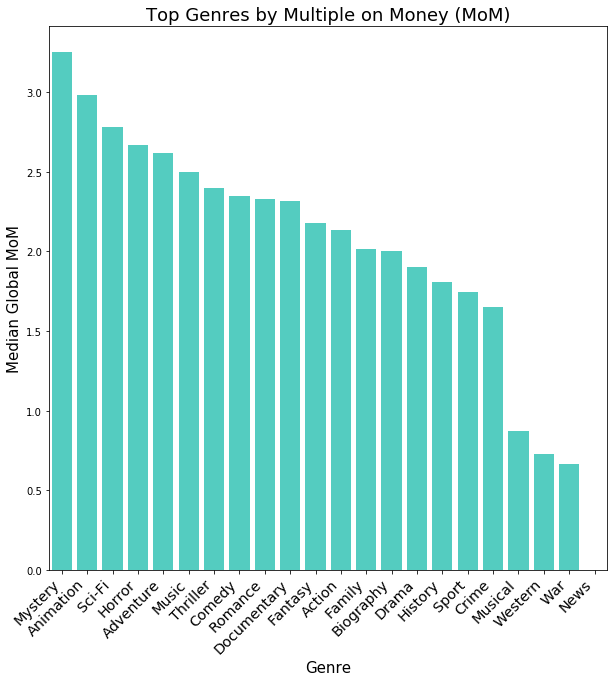

In [121]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='global_mom',data=genre_vs_mom_all, ci=None, color = 'turquoise')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Global MoM", size=15)
plt.title("Top Genres by Multiple on Money (MoM)", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

__Commentary__: The genres with the highest multiple on money (calculated as worldwide gross / production budget) are: 'Mystery', 'Animation', and 'Sci-Fi'.

In [122]:
# pull chart data
genre_vs_wwg_all = tbi_genre.groupby(['genre']).median().sort_values(by='worldwide_gross_$m',ascending=False)['worldwide_gross_$m']
genre_vs_wwg_all = genre_vs_wwg_all.reset_index()

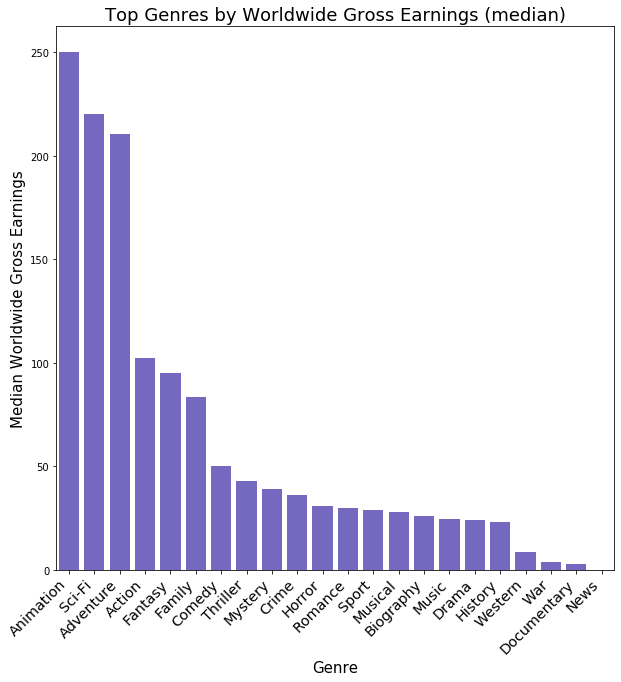

In [123]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='worldwide_gross_$m',data=genre_vs_wwg_all, ci=None, color = 'slateblue')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Worldwide Gross Earnings", size=15)
plt.title("Top Genres by Worldwide Gross Earnings (median)", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

__Commentary__: The genres with the highest median worldwide gross earnings is 'Animation', followed by 'Sci-Fi' and 'Adventure'. Especially notable are 'Animation' and 'Sci-Fi' which also ranked highly on the multiple on money analysis, indiciating that these are both high return and high absolute revenue genres.

In [124]:
# create chart data
#rgdata6 = one row per genre, movies with at least 100 numvotes and no 'averagerating' N/A, since 2010
chart2data1 = rgdata6.sort_values('averagerating', ascending=False)
chart2data1 = chart2data1.loc[chart2data1['averagerating'] > 7.5]
chart2data1 = chart2data1.groupby('genre').count()['averagerating'].nlargest(10)

Text(0.5, 1.0, 'Movies With 7.5+ Ratings')

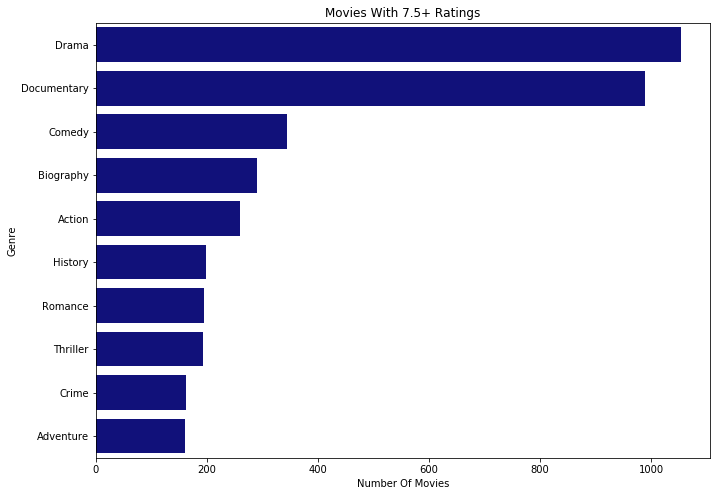

In [125]:
fig, chart2 = plt.subplots()
fig.set_size_inches(11, 8)
chart2ylabel = list(chart2data1.index)
chart2values = list(chart2data1)
chart2 = sns.barplot(x=chart2values, 
                     y=chart2ylabel,
                     color='darkblue')
chart2.set(ylabel='Genre', xlabel='Number Of Movies')
chart2.set_title('Movies With 7.5+ Ratings')

__Commentary:__ Since 2010, Drama is the genre with the most movies with a 7.5+ / 10 rating on Imdb (with at least 100 votes). Other notable genres are Documentary and Comedy.

In [126]:
# Create dataset for chart
# rgdata6 = one row per genre, movies with at least 100 numvotes and no 'averagerating' N/A, since 2010
chart3data1 = rgdata6.groupby('genre').describe()
chart3data1.drop(chart3data1.columns[8:],axis=1,inplace=True)
chart3data2 = chart3data1.loc[chart3data1['averagerating', 'count'] > 250]
chart3data2 = chart3data2.sort_values(by=('averagerating', '50%'),ascending=False)

# Manually select the top 10 Median genres
Top10Median = list(chart3data2.head(10).index)

chart3data3 = rgdata6.loc[rgdata6['genre'].isin(Top10Median)]
chart3data4 = chart3data3[['genre','averagerating']]
char3data4index = chart3data4.groupby('genre').median().sort_values(by='averagerating',ascending=False).index

Text(0.5, 1.0, 'Ratings by Genre')

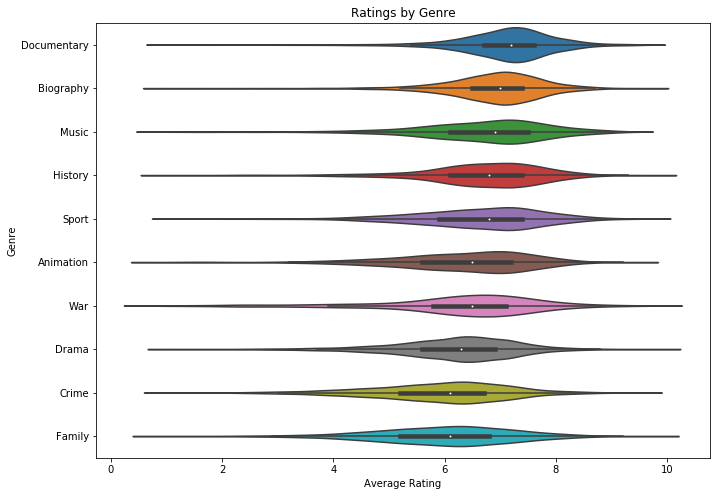

In [127]:
fig, chart3 = plt.subplots()
fig.set_size_inches(11, 8)
chart3 = sns.violinplot(x="averagerating", 
                    y="genre", 
                    data=chart3data4,
                    order=char3data4index)
chart3.set(ylabel='Genre', xlabel='Average Rating')
chart3.set_title('Ratings by Genre')

__Findings:__ Documentary is a very attractive genre given its high median rating and a distribution of ratings that really centers around the median. It also had the second highest number of top rated movies based on our analysis from question 5. Drama on the other had had the most top rated movies. However, this chart illustrates that that was largely driven by a large number of movies produced overall. When looking at the chart above, Drama ranks low on the median rating, and has a wider distribution.  

### Question 2: Who should Microsoft hire as the director?

In [128]:
# create chart data
chart1data1 = imdb.sort_values(by='averagerating',ascending = False).loc[(imdb['averagerating'].notna()) & (imdb['numvotes']>100)]
chart1data2 = chart1data1.sort_values(by='averagerating',ascending = False).loc[imdb['averagerating'] > 7.5]
chart1data3 = chart1data2.groupby('dir1_name').count().sort_values(by='tconst',ascending = False)
chart1data4 = chart1data3.loc[chart1data3['tconst'] > 3]['tconst']

Text(0.5, 1.0, 'Directors with most movies with 7.5+ ratings')

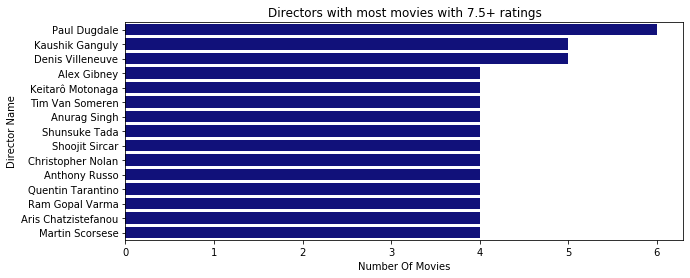

In [129]:
fig, chart1 = plt.subplots()
fig.set_size_inches(10, 4)
chart1index = list(chart1data4.index)
chart1values = list(chart1data4)
chart1 = sns.barplot(x=chart1values, 
                     y=chart1index,
                     color='darkblue')
chart1.set(ylabel='Director Name', xlabel='Number Of Movies')
chart1.set_title('Directors with most movies with 7.5+ ratings')

__Findings:__ Since 2010, Paul Dugdale has directed the most movies with a 7.5+ / 10 rating on Imdb (with at least 100 votes). Dugdale directed six, with Ganguly and Villeneuve directing five, and a group including Scorsese and Nolan directing four.

### Question 3: Which month should Microsoft release the film in?

In [130]:
# get chart data
mom_by_month = tbi.groupby(['release_month']).median().sort_values(by='release_month',ascending=True)['global_mom']
mom_by_month = mom_by_month.reset_index()

In [131]:
# format data
mom_by_month = mom_by_month.replace(to_replace = 12.0,value='December')
mom_by_month = mom_by_month.replace(to_replace = 11.0,value='November')
mom_by_month = mom_by_month.replace(to_replace = 10.0,value='October')
mom_by_month = mom_by_month.replace(to_replace = 9.0,value='September')
mom_by_month = mom_by_month.replace(to_replace = 8.0,value='August')
mom_by_month = mom_by_month.replace(to_replace = 7.0,value='July')
mom_by_month = mom_by_month.replace(to_replace = 6.0,value='June')
mom_by_month = mom_by_month.replace(to_replace = 5.0,value='May')
mom_by_month = mom_by_month.replace(to_replace = 4.0,value='April')
mom_by_month = mom_by_month.replace(to_replace = 3.0,value='March')
mom_by_month = mom_by_month.replace(to_replace = 2.0,value='February')
mom_by_month = mom_by_month.replace(to_replace = 1.0,value='January')

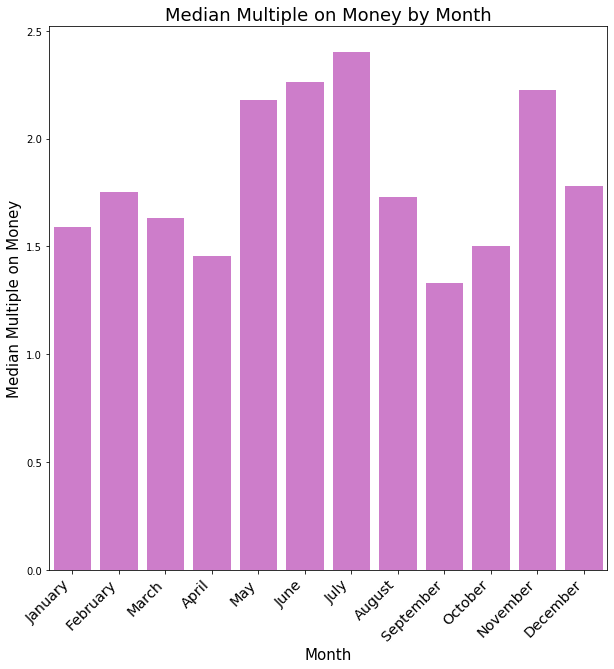

In [132]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='release_month',y='global_mom',data=mom_by_month, color='orchid',ci=None)

# set labels
plt.xlabel("Month", size=15)
plt.ylabel("Median Multiple on Money", size=15)
plt.title("Median Multiple on Money by Month", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

__Findings:__ The summer months of June and July have the highest multiple on money releases.

## Recommendation to Microsoft

Microsoft should produce a Documentary if they want to optimize for ratings — which happen to be Paul Dugdale’s area of expertise. However, if Microsoft wants to generate the highest multiple on money and gross earnings, they should produce an Animation or Sci-Fi movie, which happens to be Denis Villeneuve’s wheelhouse. They should look to release the movie during the summer months of June and July to maximize return on investment.